In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug  1 21:21:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re
from google.colab import runtime

In [ ]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/46985"
tsvData = os.path.join(dataDir,"WoSDataset_46985.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(46985, 4)


In [ ]:
print(tsvData[0:10])

[['0' 'CS'
  ' 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction        '
  '2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional two solitons are seen inf

In [ ]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [ ]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6514  4237  5483  3297 14625  7142  5687]


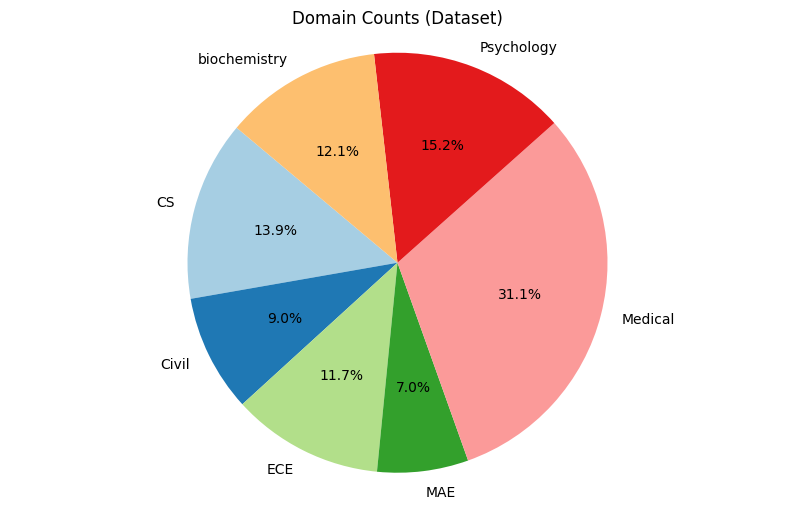

The domain CS has 6514 records in the dataset.
The domain Civil has 4237 records in the dataset.
The domain ECE has 5483 records in the dataset.
The domain MAE has 3297 records in the dataset.
The domain Medical has 14625 records in the dataset.
The domain Psychology has 7142 records in the dataset.
The domain biochemistry has 5687 records in the dataset.


In [ ]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [ ]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  46985
Shape of abstracts:  (46985,)
['nowadays the smart grid sg is becoming smarter thanks to the integration of different information and communication technologies to enhance the reliability and efficiency of the power grid however several issues should be met to ensure high sg performance among these issues we cite the problem of electric vehicles evs integration into the sg to avoid electricity intermittence due to the important load that evs can create another issue is the sg communication network security that can be attempted by malicious intruders in order to create damages and make the power grid instable in this context we propose at a first level a bayesian gametheory model that aims to integrate optimally evs into the sg and maintain the equilibrium between the offer and the demand at a second level we propose an intrusion detection system ids to protect the sg from attacks that aim to disturb the state estimation numerical results prove the efficienc

In [ ]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load BlueBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

(37588, 4)
(9397, 4)
(37588, 4)
(9397, 4)
(1880, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  37588
Shape of abstracts:  (37588,)
Number of keywords:  37588
Shape of keywords:  (37588,)
Number of domains:  37588
Shape of domains:  (37588,)
Number of labels:  37588
Shape of labels:  (37588,)
['sorting is one of the important algorithms in computer programming the ordinary 6 sorting algorithms are analyzed and compare from the algorithmic time complexity and stability the executive efficiency of 6 sorting algorithms is verified by java program the costing time and stability of 6 sorting algorithms are compared to provide certain reference for sorting algorithm'
 'the radar cross section sigmac is an objective measure of the radar visibility of an object as such sigmac is an important concept for the correct characterization of the operational performance of radar systems furthermore sigmac is equally essential for the design and development of stealth weapon systems and platforms recent years have seen the theoretical development of quantum radars that is ra

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 5184  3357  4393  2606 11732  5774  4542]


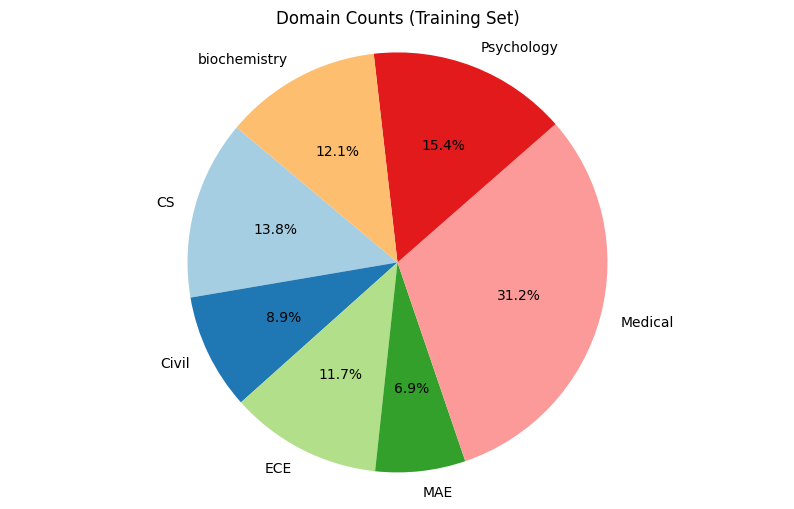

The domain CS has 5184 records in the training set.
The domain Civil has 3357 records in the training set.
The domain ECE has 4393 records in the training set.
The domain MAE has 2606 records in the training set.
The domain Medical has 11732 records in the training set.
The domain Psychology has 5774 records in the training set.
The domain biochemistry has 4542 records in the training set.


In [ ]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [ ]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  9397
Shape of abstracts:  (9397,)
Number of keywords:  9397
Shape of keywords:  (9397,)
Number of domains:  9397
Shape of domains:  (9397,)
Number of labels:  9397
Shape of labels:  (9397,)
['antiretroviral therapy art is increasingly being used as an hivprevention tool administered to uninfected people with ongoing hiv exposure as preexposure prophylaxis prep and to infected people to reduce their infectiousness we used a modelling approach to determine the optimal populationlevel combination of art and prep allocations required in south africa to maximize programme effectiveness for four outcome measures new infections infectionyears death and cost we considered two different strategies for allocating treatment one that selectively allocates drugs to sex workers and one that does not we found that for low treatment availability prevention through prep to the general population or prep and art to sex workers is key to maximizing effectiveness while for higher dru

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1330  880 1090  691 2893 1368 1145]


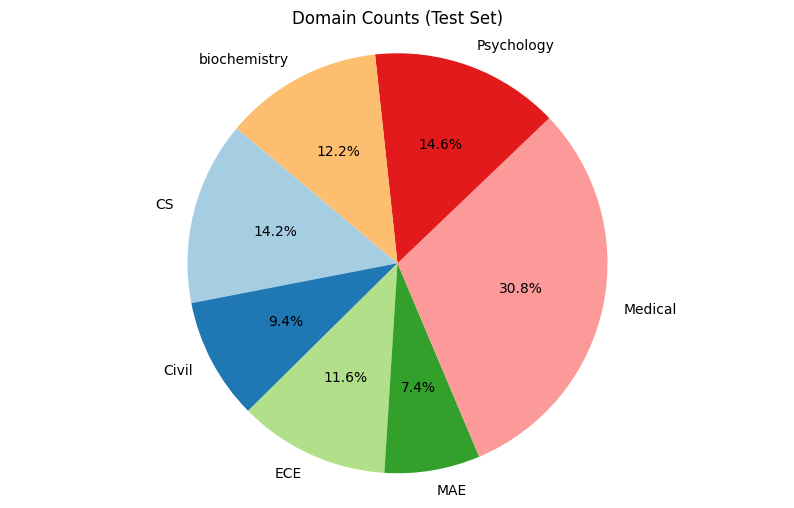

The domain CS has 1330 records in the test set.
The domain Civil has 880 records in the test set.
The domain ECE has 1090 records in the test set.
The domain MAE has 691 records in the test set.
The domain Medical has 2893 records in the test set.
The domain Psychology has 1368 records in the test set.
The domain biochemistry has 1145 records in the test set.


In [ ]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [ ]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  1880
Shape of abstracts:  (1880,)
Number of keywords:  1880
Shape of keywords:  (1880,)
Number of domains:  1880
Shape of domains:  (1880,)
Number of labels:  1880
Shape of labels:  (1880,)
['over the last 30 years cheerleading has increased dramatically in popularity and has evolved from leading the crowd in cheers at sporting events into a competitive yearround sport involving complex acrobatic stunts and tumbling consequently cheerleading injuries have steadily increased over the years in both number and severity sprains and strains to the lower extremities are the most common injuries although the overall injury rate remains relatively low cheerleading has accounted for approximately 66 of all catastrophic injuries in high school girl athletes over the past 25 years risk factors for injuries in cheerleading include higher bmi previous injury cheering on harder surfaces performing stunts and supervision by a coach with low level of training and experience this 

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [281 162 225 132 599 257 224]


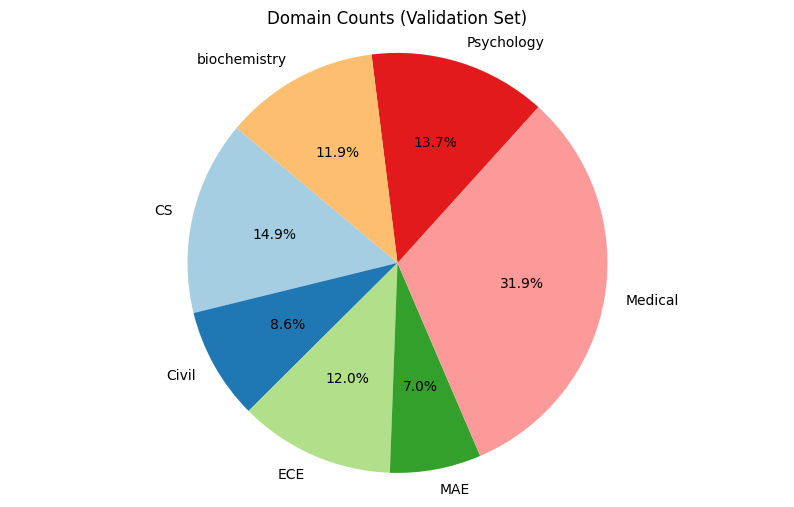

The domain CS has 281 records in the vaidation set.
The domain Civil has 162 records in the vaidation set.
The domain ECE has 225 records in the vaidation set.
The domain MAE has 132 records in the vaidation set.
The domain Medical has 599 records in the vaidation set.
The domain Psychology has 257 records in the vaidation set.
The domain biochemistry has 224 records in the vaidation set.


In [ ]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [ ]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,2].tolist(), # Keywords 2
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [ ]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(37588, 4)
(9397, 4)
(1880, 4)


In [ ]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  37588
Label length  1880
Label length  9397


In [ ]:
# Load BlueBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
model.config

BertConfig {
  "_name_or_path": "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 1175/1175 [40:11<00:00,  2.05s/batch]


Epoch 1/20
  Train Loss: 0.7285903926479056
  Val Micro F1: 0.7856382978723404
  Time: 40m 52s


Epoch 2/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.05s/batch]


Epoch 2/20
  Train Loss: 0.4912283867407352
  Val Micro F1: 0.7973404255319149
  Time: 40m 55s


Epoch 3/20: 100%|██████████| 1175/1175 [40:13<00:00,  2.05s/batch]


Epoch 3/20
  Train Loss: 0.3474492208025557
  Val Micro F1: 0.7941489361702128
  Time: 40m 55s


Epoch 4/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.05s/batch]


Epoch 4/20
  Train Loss: 0.2253684528386022
  Val Micro F1: 0.7872340425531915
  Time: 40m 55s


Epoch 5/20: 100%|██████████| 1175/1175 [40:12<00:00,  2.05s/batch]


Epoch 5/20
  Train Loss: 0.14840668401185503
  Val Micro F1: 0.7824468085106383
  Time: 40m 53s


Epoch 6/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.05s/batch]


Epoch 6/20
  Train Loss: 0.09873954627890774
  Val Micro F1: 0.7824468085106383
  Time: 40m 55s


Epoch 7/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.05s/batch]


Epoch 7/20
  Train Loss: 0.07435961920146315
  Val Micro F1: 0.7882978723404257
  Time: 40m 55s


Epoch 8/20: 100%|██████████| 1175/1175 [40:12<00:00,  2.05s/batch]


Epoch 8/20
  Train Loss: 0.05753270299541714
  Val Micro F1: 0.7803191489361703
  Time: 40m 53s


Epoch 9/20: 100%|██████████| 1175/1175 [40:12<00:00,  2.05s/batch]


Epoch 9/20
  Train Loss: 0.03928660123285768
  Val Micro F1: 0.7867021276595745
  Time: 40m 54s


Epoch 10/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.05s/batch]


Epoch 10/20
  Train Loss: 0.0327197798092613
  Val Micro F1: 0.7840425531914894
  Time: 40m 55s


Epoch 11/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.06s/batch]


Epoch 11/20
  Train Loss: 0.026646512704981896
  Val Micro F1: 0.7851063829787234
  Time: 40m 56s


Epoch 12/20: 100%|██████████| 1175/1175 [40:15<00:00,  2.06s/batch]


Epoch 12/20
  Train Loss: 0.02203676732303296
  Val Micro F1: 0.773936170212766
  Time: 40m 56s


Epoch 13/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.06s/batch]


Epoch 13/20
  Train Loss: 0.015637312189001214
  Val Micro F1: 0.7888297872340425
  Time: 40m 55s


Epoch 14/20: 100%|██████████| 1175/1175 [40:15<00:00,  2.06s/batch]


Epoch 14/20
  Train Loss: 0.013552913816410899
  Val Micro F1: 0.7936170212765957
  Time: 40m 56s


Epoch 15/20: 100%|██████████| 1175/1175 [40:14<00:00,  2.06s/batch]


Epoch 15/20
  Train Loss: 0.01263570451205522
  Val Micro F1: 0.7893617021276595
  Time: 40m 55s


Epoch 16/20: 100%|██████████| 1175/1175 [40:15<00:00,  2.06s/batch]


Epoch 16/20
  Train Loss: 0.008325109607035785
  Val Micro F1: 0.7872340425531915
  Time: 40m 57s


Epoch 17/20: 100%|██████████| 1175/1175 [40:16<00:00,  2.06s/batch]


Epoch 17/20
  Train Loss: 0.006428029944558961
  Val Micro F1: 0.7872340425531915
  Time: 40m 57s


Epoch 18/20: 100%|██████████| 1175/1175 [40:15<00:00,  2.06s/batch]


Epoch 18/20
  Train Loss: 0.004662343617949754
  Val Micro F1: 0.7888297872340425
  Time: 40m 56s


Epoch 19/20: 100%|██████████| 1175/1175 [40:16<00:00,  2.06s/batch]


Epoch 19/20
  Train Loss: 0.0034124449576998775
  Val Micro F1: 0.7920212765957448
  Time: 40m 57s


Epoch 20/20: 100%|██████████| 1175/1175 [40:16<00:00,  2.06s/batch]


Epoch 20/20
  Train Loss: 0.0027251947744050685
  Val Micro F1: 0.7888297872340425
  Time: 40m 57s


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1108   55   23   38   32   26   48]
 [  55  884    9   65   53   17    7]
 [  28   14 1029   18   28  220   31]
 [  50   56   15  494   38   24   14]
 [  47   35   24   48  703   16    7]
 [  18   14  191    6   16 2485  163]
 [  28    6   35   11   10  252  803]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1330
           1       0.83      0.81      0.82      1090
           2       0.78      0.75      0.76      1368
           3       0.73      0.71      0.72       691
           4       0.80      0.80      0.80       880
           5       0.82      0.86      0.84      2893
           6       0.75      0.70      0.72      1145

    accuracy                           0.80      9397
   macro avg       0.79      0.78      0.79      9397
weighted avg       0.80      0.80      0.80      9397

Macro F1 Score: 0.7854027037302137
Micro F1 Score: 0.7987655634777056
Weighted F1 Score: 0.7

In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/BlueBERT_WoS_Keywords_46985')

In [ ]:
print('End of the runtime!')

In [ ]:
runtime.unassign()